### Import the libraries and download the required nltk data set

In [ ]:
import string
import numpy as np
from collections import Counter, defaultdict
from sklearn import svm
from scipy import sparse

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')

import tarfile
import zipfile

import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Download the data set and extract. Extract test data also (if already uploaded)

In [ ]:
file_name = 'lingspam_public.tar.gz'
file_path = '/content/'+ file_name
if os.path.exists(file_path) == False :
  !wget http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz --no-check-certificate

  # open file
  tar_file = tarfile.open(file_path)

  tar_file.extractall('/content')

test_zip_file = '/content/test.zip'
if os.path.exists(test_zip_file) == True :
  with zipfile.ZipFile(test_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content')

--2022-04-16 04:33:51--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2022-04-16 04:33:52--  http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.230
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2022-04-16 04:33:53--  https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 11564714 (11M) [appli

### Class definition for the classifier

In [ ]:
class EmailClassifier(object):

  def __init__(self, kernels, penalties, max_df =1.0):
    self.max_df = max_df # to remove corpus specific stop words
    self.tokenizer = TreebankWordTokenizer()
    self.lemmatizer = WordNetLemmatizer()

    self.stop_words = stopwords.words('english')
    punctuations = list(string.punctuation)
    self.stop_words += punctuations # used for removing stopwords and punctuations

    self.kernels = kernels
    self.penalties = penalties

  def __pre_process_text(self, data_df):
    data_df['text'] = data_df['text'].apply(lambda x: ' '.join([word for word \
                                                in self.tokenizer.tokenize(str(x).replace('\\n', ' ')) ]))
    data_df['text'] = data_df['text'].apply(lambda x: ' '.join([self.lemmatizer.lemmatize(word.lower()) \
                                                for word in x.split(' ')]))
    data_df['text'] = data_df['text'].apply(lambda x: ' '.join([word for word in x.split(' ')\
                                                        if word not in (self.stop_words)]))
    return data_df

  def __get_vocab(self, df):
    num_docs = len(df)

    document_freq = defaultdict(int)
    
    for i in range(num_docs):

      words = df.iloc[i, 1].split(' ')

      for word in set(words):
        if(len(word) > 2):
          document_freq[word] += 1

    unique_words = set([word for word in list(document_freq) if (document_freq[word]/num_docs) <= self.max_df])
    sorted_words = sorted(unique_words)
    self.vocab = {}
    for index, word in enumerate(sorted_words):
      self.vocab[word] = index

  def __get_feature_matrix(self, df, generate_vocab=True):
    
    if generate_vocab==True:
      self.__get_vocab(df)

    num_docs = len(df) 

    row, col, val = [], [], []

    for i in range(num_docs):
      words = df.iloc[i, 1].split(' ')

      word_count_dict = dict(Counter(words))

      for word, count in word_count_dict.items():
        
        if(len(word) > 2):
          col_idx = self.vocab.get(word, -1)
          if col_idx >= 0:
            row.append(i)
            col.append(col_idx)
            val.append(count)
    
    return sparse.csr_matrix( (val, (row, col)), shape=(num_docs, len(self.vocab)) )

  def __do_k_fold_validation(self, train_dataset_df, kernel, penalty, num_folds=10):
    
    avg_score_all = []
    df_list = np.array_split(train_dataset_df, num_folds)
    for i in range(num_folds):
      test_df = df_list[i]

      train_df_list = []
      for j in range(num_folds):
        if j != i:
          train_df_list.append(df_list[j])

      train_df = pd.concat(train_df_list)

      train_feature_matrix = self.__get_feature_matrix(train_df)

      svm_classifier = svm.SVC(C=penalty, kernel=kernel)
      svm_classifier.fit(train_feature_matrix, train_df['label'].values)

      test_feature_matrix = self.__get_feature_matrix(test_df, generate_vocab=False)
      score = svm_classifier.score(test_feature_matrix, test_df['label'].values)
      avg_score_all.append(score)
    
    return np.average(avg_score_all)


  def fit(self, train_dataset_df, num_folds=10):

    train_dataset_df = self.__pre_process_text(train_dataset_df)

    self.parameters = []    
    for kernel in self.kernels :        
        for penalty in self.penalties :            
            self.parameters.append(( kernel, penalty ))

    self.score_all = []
    for kernel, penalty in self.parameters:
      print('Cross validating for {} and {}'.format(kernel, penalty))
      score = self.__do_k_fold_validation(train_dataset_df, kernel, penalty, num_folds)
      self.score_all.append(score)
    
    sort_index = np.argsort(self.score_all)
    sorted_parameters = np.array(self.parameters)[sort_index]

    self.best_kernel, self.best_penalty = sorted_parameters[-1] #based on max score

    train_feature_matrix = self.__get_feature_matrix(train_dataset_df)
    self.svm_classifier = svm.SVC(C=float(self.best_penalty), kernel=self.best_kernel)
    self.svm_classifier.fit(train_feature_matrix, train_dataset_df['label'].values)

  def get_params(self):
    return self.parameters, self.score_all, self.best_kernel, self.best_penalty

  def fit_without_CV(self, input_dataset_df):

    msk = np.random.rand(len(input_dataset_df)) < 0.8
    train_df = input_dataset_df[msk]
    test_df = input_dataset_df[~msk]

    train_df = self.__pre_process_text(train_df)
    test_df = self.__pre_process_text(test_df)

    train_feature_matrix = self.__get_feature_matrix(train_df)

    self.svm_classifier = svm.SVC(C=16)
    self.svm_classifier.fit(train_feature_matrix, train_df['label'].values)

    test_feature_matrix = self.__get_feature_matrix(test_df, generate_vocab=False)
    print(self.svm_classifier.score(test_feature_matrix, test_df['label'].values))
    print(self.svm_classifier.get_params())

  def predict(self, test_dataset_df):
    test_df = self.__pre_process_text(test_dataset_df)
    test_feature_matrix = self.__get_feature_matrix(test_df, generate_vocab=False)

    return(self.svm_classifier.predict(test_feature_matrix))

### Read the data set and run the classifier

In [ ]:
def read_dataset():
  dataset_folder = 'lingspam_public/bare'

  dataset_df = pd.DataFrame(columns = ['label', 'text'])

  for root, subdirs, files in os.walk('/content/'+ dataset_folder):
    for filename in files:

      file_path = os.path.join(root, filename)
      with open(file_path, 'r') as f:
        f_content = f.read()
        if filename.startswith('spmsg'):
          dataset_df.loc[len(dataset_df.index)] = ['1', f_content]
        else:
          dataset_df.loc[len(dataset_df.index)] = ['0', f_content]
  
  return dataset_df 

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
#kernels = ['poly', 'rbf']
penalties = range(1, 20, 1)

input_dataset_df = read_dataset()
email_classifier = EmailClassifier(kernels, penalties)
email_classifier.fit(input_dataset_df)
parameters, scores, best_kernel, best_penalty = email_classifier.get_params()
#print(parameters, scores, best_kernel, best_penalty)

### Plot the cross validation data

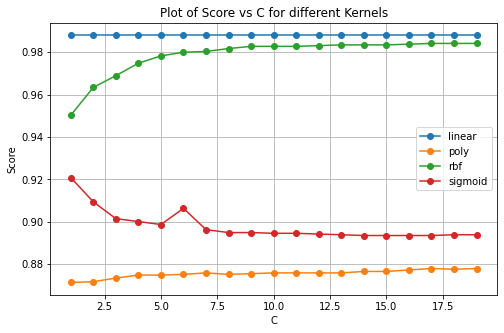

In [ ]:
import matplotlib.pyplot as plt

plot_dict ={}
for i in range(len(parameters)):
  kernel, _ = parameters[i]

  if kernel not in plot_dict:
    plot_dict[kernel] = []

  plot_dict[kernel].append(scores[i])

#print(plot_dict)

plt.figure(figsize=(8, 5))
for key in plot_dict:
  plt.plot(penalties, plot_dict[key], 'o-', label=key)
  
plt.title('Plot of Score vs C for different Kernels')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

### Predict the classes of test emails using the classifier

In [ ]:
def get_test_email_dataset():
  email_test_df = pd.DataFrame(columns = ['label', 'text'])

  test_folder = './test'
  if os.path.exists(test_folder) == True :
    for root, subdirs, files in os.walk(test_folder):
      for filename in files:
        file_path = os.path.join(root, filename)

        with open(file_path, 'r') as f:
          f_content = f.read()
          email_test_df.loc[len(email_test_df.index)] = [filename, f_content]
  else:
    print("test folder doesn't exist")

  return email_test_df

test_data = get_test_email_dataset()
if len(test_data) > 0:
  predictions = email_classifier.predict(test_data)
  email_file_names = np.array(test_data['label'])
  predictions = predictions.astype(np.int32)
  for i in range(len(email_file_names)):
    print(email_file_names[i], predictions[i])

email1.txt 0
email2.txt 1


In [ ]:
print(parameters, scores, best_kernel, best_penalty)

[('linear', 1), ('linear', 2), ('linear', 3), ('linear', 4), ('linear', 5), ('linear', 6), ('linear', 7), ('linear', 8), ('linear', 9), ('linear', 10), ('linear', 11), ('linear', 12), ('linear', 13), ('linear', 14), ('linear', 15), ('linear', 16), ('linear', 17), ('linear', 18), ('linear', 19), ('poly', 1), ('poly', 2), ('poly', 3), ('poly', 4), ('poly', 5), ('poly', 6), ('poly', 7), ('poly', 8), ('poly', 9), ('poly', 10), ('poly', 11), ('poly', 12), ('poly', 13), ('poly', 14), ('poly', 15), ('poly', 16), ('poly', 17), ('poly', 18), ('poly', 19), ('rbf', 1), ('rbf', 2), ('rbf', 3), ('rbf', 4), ('rbf', 5), ('rbf', 6), ('rbf', 7), ('rbf', 8), ('rbf', 9), ('rbf', 10), ('rbf', 11), ('rbf', 12), ('rbf', 13), ('rbf', 14), ('rbf', 15), ('rbf', 16), ('rbf', 17), ('rbf', 18), ('rbf', 19), ('sigmoid', 1), ('sigmoid', 2), ('sigmoid', 3), ('sigmoid', 4), ('sigmoid', 5), ('sigmoid', 6), ('sigmoid', 7), ('sigmoid', 8), ('sigmoid', 9), ('sigmoid', 10), ('sigmoid', 11), ('sigmoid', 12), ('sigmoid', 13